### Libs

In [1]:
from tqdm import tqdm
import numpy as np
import os
import random
import glob
import re
from pathlib import Path

import cv2
import geopandas as gpd
import pandas as pd

import albumentations as A

import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid, save_image
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from pytorch_model_summary import summary
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import model
import metrics
import config
import utis
import train_val_test

from matplotlib import pyplot as plt, cm
import plotly.express as px
import plotly.graph_objects as go
import plotly

plotly.offline.init_notebook_mode() # avoiding saving html files


from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

### Weights and Biases

In [2]:
!wandb login 

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


### Custom Split Dataset

In [2]:
# Paths
IMAGES_PATH = '../data/patches/images/1942'
MASK_PATH = '../data/patches/masks/1942'
BEST_MODEL = '../best_model'

FILTER_PATH = '../data/geopackages/patch_keys.gpkg'
TEST_DATASET_PATH = '../data/test_dataset'

image_paths = glob.glob(IMAGES_PATH +'/*.tif')
mask_paths = glob.glob(MASK_PATH +'/*.tif')

In [3]:
# Read file 
geo_df = gpd.read_file(FILTER_PATH) # contains the idxs with a selection of non-noisy and noisy data
geo_df['status'] = geo_df.apply(lambda x: 2 if x['index'] in [302, 365, 606, 895, 298, 698] else x['status'], axis=1) # correcting wrongly attributed category
geo_df['status'] = geo_df.apply(lambda x: np.NaN if x['index'] in [3083] else x['status'], axis=1) # correcting wrongly attributed category

# Define the filters 
filters = {
       'non_veg_idxs' : geo_df.query("status == 0")['index'],
       'veg_idxs' :  geo_df.query("status == 1")['index'], 
       'mixed': geo_df.query("status == 2")['index'], 
       'single_trees_idx' : geo_df.query("status == 3")['index'], 
       'hedgerows' : geo_df.query("status == 4")['index'], 
       #'coarse_to_very_coarse': geo_df.query("status == 5")['index'][5:]
          }

# fix bug of the test_size
data_portion = 'all_coarse_labels' # ['all_coarse_labels','coarse_plus_fine_labels', 'fine_labels', 'coarse_labels']
n_patches = 286
X_train, y_train, X_val, y_val, X_test, y_test = utis.custom_split(filters, test_size=40, 
                                                                   image_paths=image_paths, 
                                                                   mask_paths=mask_paths,  
                                                                   data_portion=data_portion,
                                                                   DEST_PATH = TEST_DATASET_PATH,
                                                                   number_training_patchs=n_patches)

In [79]:
# exclude = list(filters['non_veg_idxs']) + list(filters['veg_idxs']) + list(filters['mixed'])
# save = []
                                                                                                   
# for x in X_test:
#     x_1 = utis.get_file_index(x)
    
#     if np.isin(x_1, list(filters['non_veg_idxs'])):
#         save.append(x_1)
        
# X_test = utis.filtered_paths(image_paths, save)
# y_test = utis.filtered_paths(mask_paths, save)

### Dataloader

In [4]:
# Define transformations
val_transform = A.Compose(
    [A.Normalize(mean=(0.512), std=(0.167)),
    ToTensorV2()])

train_transform = A.Compose([
      A.Rotate(limit=40,p=0.9, border_mode=cv2.BORDER_CONSTANT), # p stands for the probability with which the transformations are applied
      A.HorizontalFlip(p=0.9),
      A.VerticalFlip(p=0.9), 
      A.Transpose(p=0.9),
      A.CLAHE(p=1),
      A.Normalize(mean=(0.512), std=(0.167)),
      ToTensorV2()])

# Datasets
train_dataset = HistoricalImagesDataset(X_train, y_train, transform=train_transform, split_type=None)
val_dataset = HistoricalImagesDataset(X_val, y_val, transform=val_transform, split_type=None)
test_dataset = HistoricalImagesDataset(X_test, y_test, transform=val_transform, split_type='test')

data = next(iter(train_dataset))
print('shape train image', data[0].shape, 'shape train mask', data[1].shape) 

# Dataloader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE, shuffle=True)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE, shuffle=True)

print("Testing set size: ", len(test_dataset))
test_dataloader = DataLoader(dataset=test_dataset, batch_size = 1)

shape train image torch.Size([1, 256, 256]) shape train mask torch.Size([256, 256])
Training set size:  2151
Validation set size:  923
Testing set size:  410


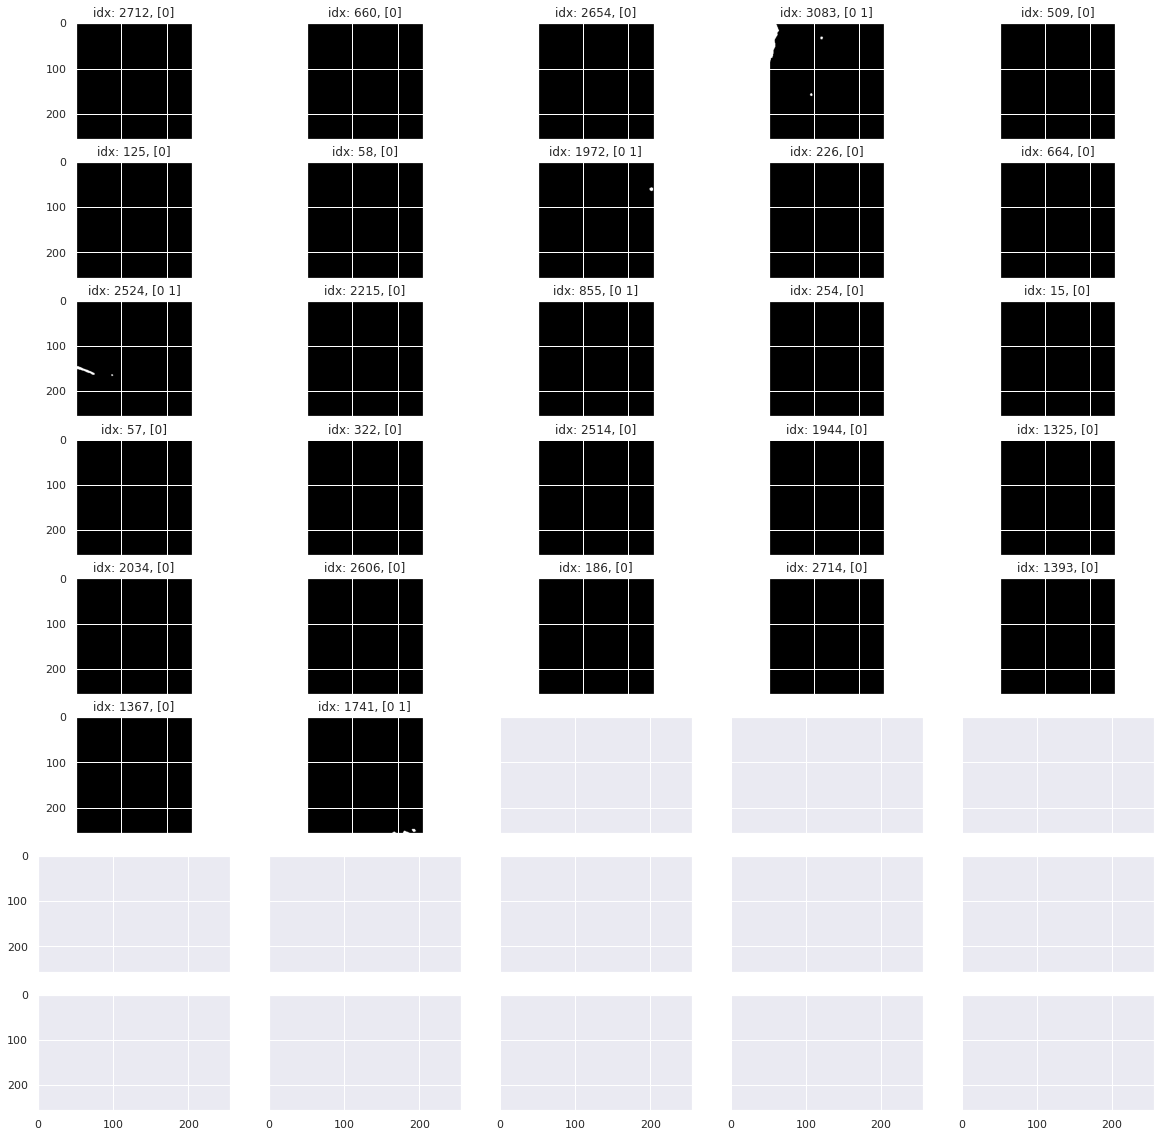

In [81]:
# Plot
n_col = 5
n_row = 8

_, axs = plt.subplots(n_row, n_col, figsize=(20,20), sharex=True, sharey=True)
axs = axs.flatten()
cmap = cm.get_cmap('gray')
# random.Random(4).shuffle(y_test)
# random.Random(4).shuffle(X_test)

for c, (i, ax) in enumerate(zip(y_test[40:80], axs)):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap=cmap, vmin=0)
    ax.set_title(f'idx: {utis.get_file_index(i)}, {np.unique(img)}')
plt.show()

In [8]:
# utis.plot_pizza(y_val, title='Test dataset')

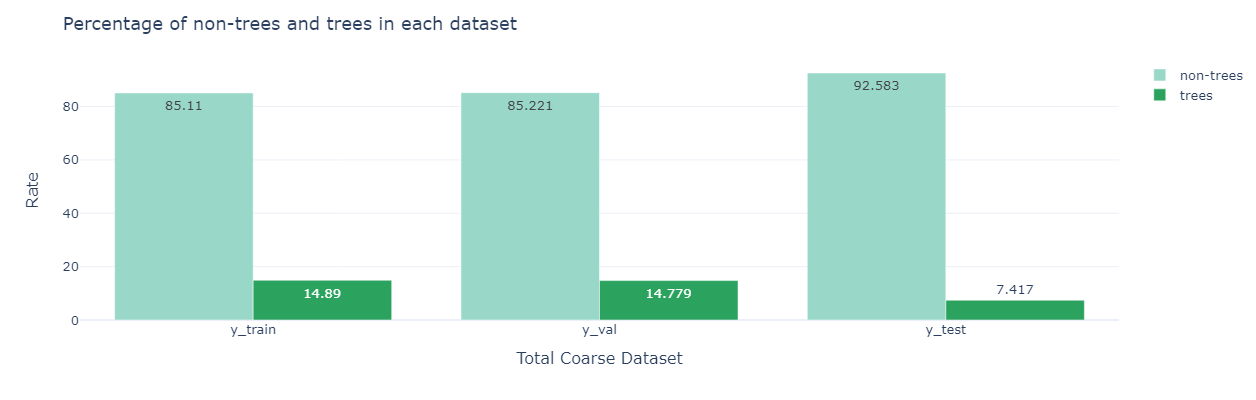

In [15]:
masks = [y_train, y_val, y_test]
names = ['y_train', 'y_val', 'y_test']

utis.bar_chat_datasets(masks, names, x_axis='Total Coarse')

### Check if CUDA is available

In [10]:
config.DEVICE

'cuda'

### KFOLD TESTS

In [1]:
    # Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
save_path = '../best_model/fine_sizes/'
n_patches = 10
save_models = {}
path_ = 'fine_sizes'


# Define X_train, X_val, X_test
data_portion = 'fine_patches_but_X_test'
X_train, y_train = utis.custom_split(filters, test_size=40, 
                                              image_paths=image_paths, 
                                              mask_paths=mask_paths,  
                                              data_portion=data_portion,
                                              DEST_PATH = config.TEST_DATASET_PATH,
                                              number_training_patchs=n_patches)
# Datasets
train_dataset = HistoricalImagesDataset(X_train, y_train, transform=train_transform, split_type=None)

# load the datasetsuscuic
# datasets = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
results = {}

dir_to_create = os.path.join(save_path, str(n_patches))
print(dir_to_create)

# # initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[]} # initialize a dictionary to store TRAINING history (keep track on training)

# # # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[]}

for fold,(train_idx, test_idx) in enumerate(kfold.split(train_dataset)):
        print('------------fold no---------{}----------------------'.format(fold))
        print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

        # best iou accuracy to save
        best_accuracy = 0.0

        # get the dataloader based on the kfold indexs
        trainloader, testloader = train_val_test.k_fold_dataloaders(
                        train_idx, 
                        test_idx, 
                        train_dataset)

        print('N of train samples', len(train_idx))
        print('N of test samples', len(test_idx))

        # Model, optmizer, loss
        unet = model.unet_model.to(config.DEVICE) # initialize the model
        opt = optim.Adam(unet.parameters(), lr=config.LR)
        lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        scaler = GradScaler()
        # scheduler = ReduceLROnPlateau(opt, mode='max', factor=0.1, patience=10, verbose=True)
        scheduler = StepLR(opt, step_size=20, gamma=0.1)


        for epoch in range(0, config.NUM_EPOCHS):        
            trained = train_val_test.train(unet, 
                                           trainloader, 
                                           opt=opt, 
                                           lossFunc=lossFunc, 
                                           epoch=epoch, 
                                           scaler=scaler, 
                                           training_history=training_history)

            validated = train_val_test.validation(unet, 
                                   testloader, 
                                   lossFunc, 
                                   epoch,
                                   validation_history)

            scheduler.step()

            # create a folder named with the number of patches used o train
            if not os.path.exists(dir_to_create):
                utis.create_new_dir(dir_to_create)

            # Save best model
            if validated["IoU_val"][-1] > best_accuracy and epoch > 5: # maybe add a minimum number of epochs as conditions
                # Saving the model
                results.update([(fold, [unet.state_dict(), validated["IoU_val"][-1]])])
                # utis.save_model(unet, dir_to_create, fold, validated["IoU_val"][-1],epoch, path_)
                best_accuracy = validated["IoU_val"][-1]
          
        # save the best models per fold 
        [save_model(model[0], dir_to_create, key, model[1],epoch, path_) for key, model in results.items()] # 
        
        del unet # delete model instance after each fold
        del opt # delete the optmizer instance after each fold
        torch.cuda.empty_cache() # clean cuda cache

NameError: name 'KFold' is not defined

In [17]:
def save_model(model_to_save, 
               dir_to_create, 
               fold, 
               dic_results, 
               epoch, 
               path_to_save_models) -> None:
    
    # path name
    path_save = f'{dir_to_create}/fold_{fold}_epoch_{epoch}_iou_{dic_results:.3f}.pth'
    
    # remove previous files saved with the same fold name
    path_list = glob.glob(dir_to_create + '/*')
    [os.remove(f) for f in path_list if f'fold_{fold}' in f] #27 or 26
    
    # save the model
    torch.save(model_to_save, path_save)

In [15]:
results[0][1]

0.9734398722648621

In [18]:
[save_model(model, dir_to_create, key, validated["IoU_val"][-1],epoch, path_) for key, model in results.items()]

dict_keys([0, 1, 2, 3, 4])

### MAIN

In [8]:
# WandB – Initialize a new run
# wandb.init(entity="vibferreira", project="master_thesis")

# classes
classes = ('no_vegetation', 'vegetation')

# Initialize model
unet = model.unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

opt = optim.Adam(unet.parameters(), lr=config.LR)
# opt = optim.SGD(unet.parameters(), lr=config.LR, momentum=0.95, weight_decay=0.01)
# scheduler = ReduceLROnPlateau(opt, mode='max', factor=0.1, patience=10, verbose=True)
scheduler = StepLR(opt, step_size=20, gamma=0.1)

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[],"f1score":[], "avgDice":[]}

# # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[], "f1score_val":[]}

# Using log="all" log histograms of parameter values in addition to gradients
# wandb.watch(unet, log="all")

# Autocasting 
scaler = GradScaler()

# initialize best accuracy
best_accuracy = 0.0
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

# loop = tqdm(range(config.NUM_EPOCHS))
iter_ = 0
for e in range(config.NUM_EPOCHS):
    trained = train_val_test.train(unet, train_dataloader, opt, lossFunc, epoch=e, scaler=scaler, training_history=training_history)
    validated = train_val_test.validation(unet, val_dataloader, lossFunc, epoch=e, validation_history=validation_history)
    scheduler.step()
    
    # Save best model
    if validated['IoU_val'][-1] > best_accuracy and e > 10: # maybe add a minimum number of epochs as conditions
        utis.save_best_model(unet, BEST_MODEL, validated, e, data_portion, rate_of_coarse_labels=n_patches)
        best_accuracy = validation_history['IoU_val'][-1]

Training the network for 100 epochs, with a batch size of 16


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 15.78 GiB total capacity; 1.84 GiB already allocated; 50.69 MiB free; 1.96 GiB reserved in total by PyTorch)

NameError: name 'training_history' is not defined

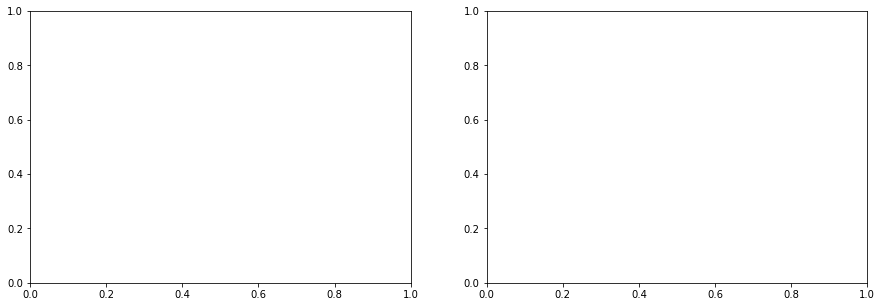

In [8]:
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(training_history["avg_train_loss"], label= 'train')
ax[0].plot(validation_history['avg_val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(training_history['IoU'], label= 'train')
ax[1].plot(validation_history['IoU_val'], label='val')
ax[1].set_title('IOU')
ax[1].legend()
plt.show()

In [31]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)
# print('Attention type: ', config.ATT)
# unet = unet = model.unet_model.to(config.DEVICE)
# x = torch.zeros((1, 1, 256, 256))
# x = x.to(config.DEVICE)
# print(summary(unet, x, show_input=True, batch_size=config.BATCH_SIZE))

Attention type:  None
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
           Layer (type)                                                                                                 Input Shape         Param #     Tr. Param #
   MobileNetV2Encoder-1                                                                                            [1, 1, 256, 256]       2,223,296       2,223,296
          UnetDecoder-2     [1, 1, 256, 256], [1, 16, 128, 128], [1, 24, 64, 64], [1, 32, 32, 32], [1, 96, 16, 16], [1, 1280, 8, 8]       4,404,928       4,404,928
               Conv2d-3                                                                                           [1, 16, 256, 256]             145             145
             Identity-4                                                                                            [1, 1, 256, 256]               0          

### KFold models Evaluation

In [5]:
exclude = list(filters['non_veg_idxs']) + list(filters['veg_idxs']) + list(filters['mixed'])
save = []
                                                                                                   
for x in X_test:
    x_1 = utis.get_file_index(x)
    
    if not np.isin(x_1, exclude):
        save.append(x_1)
        
X_test = utis.filtered_paths(image_paths, save)
y_test = utis.filtered_paths(mask_paths, save)
test_dataset = HistoricalImagesDataset(X_test, y_test, transform=val_transform, split_type='test')
test_dataloader = DataLoader(dataset=test_dataset, batch_size = 1)

In [15]:
# df = pd.DataFrame(means, index=['h', 'j'])
my_file = Path('../best_model/coarse_sizes')
my_file_2 = Path('../best_model/fine_sizes')

# means on the kfold test set
fine_df = utis.get_DF_with_the_means(my_file_2, label='kfold') 
coarse_df = utis.get_DF_with_the_means(my_file, label='kfold') 

# means on the independent test set
# fine_df_idp = utis.get_DF_with_the_means(my_file_2, 
#                                          label='independent_test_set', 
#                                          independent_test=True, 
#                                          test_dataloader=test_dataloader, 
#                                          X_test=X_test)

# coarse_df_idp = utis.get_DF_with_the_means(my_file, 
#                                            label='independent_test_set', 
#                                            independent_test=True, 
#                                            test_dataloader=test_dataloader, 
#                                            X_test=X_test)

# final_df = pd.concat([fine_df, coarse_df, fine_df_idp, coarse_df_idp])
final_df = pd.concat([fine_df, coarse_df])
final_df  = final_df[final_df['N_PATCHES'] != 411]
# final_df = pd.concat([fine_df, coarse_df])

# # fig = px.line(final_df, x="NUMBER OF PATCHES", y="IOU", title='IoU by Number of patches', labels={"data_portion": "Data"}, color="data_portion")
# # fig.show()

In [16]:
final_df

N_PATCHES    IOU  STD_DEV  DATA_PORTION
11         10  0.775    0.246    fine_kfold
8          20  0.819    0.211    fine_kfold
2          55  0.846    0.223    fine_kfold
4          90  0.869    0.154    fine_kfold
3         125  0.940    0.022    fine_kfold
1         160  0.946    0.018    fine_kfold
6         195  0.959    0.022    fine_kfold
9         230  0.957    0.019    fine_kfold
10        265  0.956    0.016    fine_kfold
12        300  0.959    0.015    fine_kfold
5         335  0.972    0.010    fine_kfold
0         370  0.938    0.012    fine_kfold
7          20  0.774    0.315  coarse_kfold
2          55  0.879    0.223  coarse_kfold
4          90  0.914    0.121  coarse_kfold
3         125  0.958    0.021  coarse_kfold
1         160  0.958    0.021  coarse_kfold
6         195  0.974    0.015  coarse_kfold
8         230  0.967    0.018  coarse_kfold
9         265  0.971    0.010  coarse_kfold
10        300  0.973    0.008  coarse_kfold
5         335  0.955    0.019  coarse_kfold
0         370  0.961    0.008  coarse_kfold

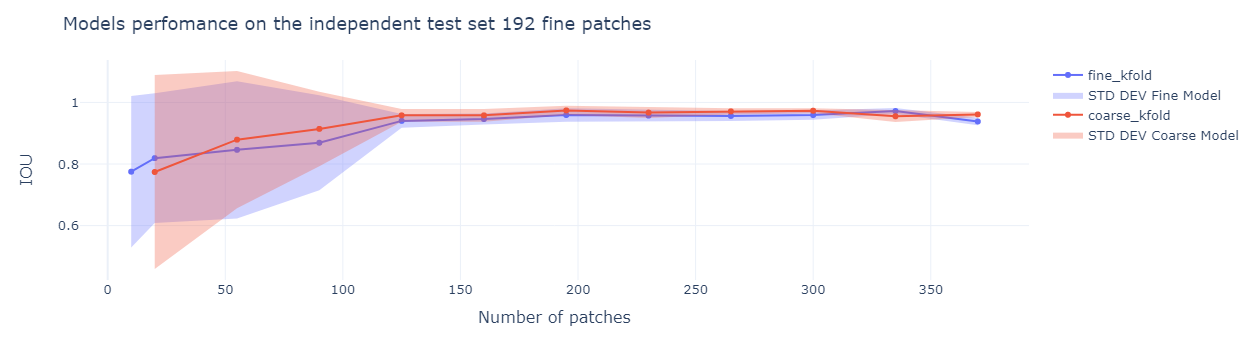

In [77]:
# final_df = final_df.query("DATA_PORTION == ['coarse_independent_test_set', 'fine_independent_test_set'] ")

fig = line(
    data_frame = final_df,
    x = 'N_PATCHES',
    y = 'IOU',
    error_y = 'STD_DEV',
    error_y_mode = 'band', # Here you say `band` or `bar`.
    color = 'DATA_PORTION',
    markers = '.',
    # labels={'fine_kfold': "Mean IOU Fine Model", 'coarse_kfold': "Mean IOU Coarse Model"},
    template="plotly_white",
    
)

fig.update_layout(
    title = f'Models perfomance on the independent test set {len(X_test)} fine patches',
    xaxis_title="Number of patches",
    yaxis_title=" IOU",
    legend_title="",
    font=dict(size=13))
    
fig.show()

### Predictions

In [25]:
categories = list(filters.keys())[1:]
categories
# [categories]

['veg_idxs', 'mixed', 'single_trees_idx', 'hedgerows']

In [32]:
def metrics_total_coarse_models(files, 
                                test_dataloader, 
                                X_test):
    
    # get the model
    print('File path', model_path)
    model_ = model.unet_model.to(config.DEVICE)
    model_.load_state_dict(torch.load(model_path))
    
    results = {}

    # make the predicitions
    y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder, print_pred=False, save_patches=False)

    # compute the acc metrics
    # Precision and recall per class
    cr = classification_report(y_true, y_hat, target_names=['Non-trees', 'Trees'], output_dict=True)

    # mean IoU
    all_metrics = metrics.metrics(y_hat, y_true)
    iou = all_metrics['iou']

    results.update({
        'iou': iou, 
        'precision': cr['Trees']['precision'],
        'recall': cr['Trees']['recall'],
        'f1-score': cr['Trees']['f1-score'],
        'precision_non_veg': cr['Non-trees']['precision'],
        'recall_non_veg': cr['Non-trees']['recall'],
        'f1-score_non_veg': cr['Non-trees']['f1-score']
    })
        
    return results

In [37]:
my_file = Path('../best_model/coarse_sizes/370')
files = list(my_file.glob('**/*'))[:2]

def metrics_small_coarse_or_fine_models(files, 
                                        test_dataloader, 
                                        X_test):
    
    print('File path', files)
    
    # variables to save
    iou_mean = np.zeros(len(files))

    precision_mean = np.zeros(len(files))
    recall_mean = np.zeros(len(files))
    f1_score_mean = np.zeros(len(files))

    precision_mean_non_tree = np.zeros(len(files))
    recall_mean_non_tree = np.zeros(len(files))
    f1_score_mean_non_tree = np.zeros(len(files))

    results = {}

    for n, i in enumerate(files):
        model_ = model.unet_model.to(config.DEVICE)
        model_.load_state_dict(torch.load(i))

        # make the predicitions
        y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, None, print_pred=False, save_patches=False)

        # compute the acc metrics
        # Precision and recall per class
        cr = classification_report(y_true, y_hat, target_names=['Non-trees', 'Trees'], output_dict=True)

        # mean IoU
        iou = metrics.metrics(y_hat, y_true)['iou']

        iou_mean[n] = iou

        precision_mean[n] = cr['Trees']['precision']
        recall_mean[n] = cr['Trees']['recall']
        f1_score_mean[n] = cr['Trees']['f1-score']

        precision_mean_non_tree[n] = cr['Non-trees']['precision']
        recall_mean_non_tree[n] = cr['Non-trees']['recall']
        f1_score_mean_non_tree[n] = cr['Non-trees']['f1-score']

        results.update({
            'iou': iou_mean.mean(), 
            'precision': precision_mean.mean(),
            'recall': recall_mean.mean(),
            'f1-score': f1_score_mean.mean(),
            'precision_non_veg': precision_mean_non_tree.mean(),
            'recall_non_veg': recall_mean_non_tree.mean(),
            'f1-score_non_veg': f1_score_mean_non_tree.mean()
        })
        
    return results

In [38]:
# set the model in evaluation model

BEST_MODEL = '../best_model/'
files = glob.glob(BEST_MODEL + '/*.pth')[0]

my_file = Path('../best_model/coarse_sizes/370')
files = list(my_file.glob('**/*'))[:2]

def get_summary_acc_tables(files, categories, kfold=False):
    
    dic = {'test_dataset_category':[],
           'label': [],
           'precision':[],
           'recall':[],
           'f1-score':[],
           'mean_iou':[]
          }

    for cat in categories:
        print(cat)
        # Get the test dataset
        if cat == 'veg_idxs':
            idxs = list(filters[cat]) + list(filters['non_veg_idxs'])
            X_test = utis.filtered_paths(image_paths, idxs)
            y_test = utis.filtered_paths(mask_paths, idxs)
            cat = 'pure_patches'
        else:
            X_test = utis.filtered_paths(image_paths, filters[cat])
            y_test = utis.filtered_paths(mask_paths, filters[cat])

        # Send to Dataset and Dataloader
        test_dataset = HistoricalImagesDataset(X_test, y_test, transform=val_transform, split_type='test')
        test_dataloader = DataLoader(dataset=test_dataset, batch_size = 1)

        # make the predicitions
        if kfold:
            results = metrics_small_coarse_or_fine_models(files, test_dataloader, X_test)
        else:
            results = metrics_small_coarse_or_fine_models(files, test_dataloader, X_test)

        dic['test_dataset_category'].append(cat)
        dic['label'].append('trees')
        dic['mean_iou'].append(results['iou'])
        dic['precision'].append(results['precision'])
        dic['recall'].append(results['recall'])
        dic['f1-score'].append(results['f1-score'])

        dic['test_dataset_category'].append(cat)
        dic['label'].append('non-trees')
        dic['mean_iou'].append(results['iou'])
        dic['precision'].append(results['precision_non_veg'])
        dic['recall'].append(results['recall_non_veg'])
        dic['f1-score'].append(results['f1-score_non_veg'])

    df = pd.DataFrame(dic)
    df = df.astype({'mean_iou': 'float64'})
    df.iloc[:, 2:] = df.iloc[:, 2:].apply(lambda x: pd.Series.round(x, 4)*100)
    
    return df

veg_idxs
mixed
single_trees_idx
hedgerows


In [43]:
categories = list(filters.keys())[3:]
categories

['single_trees_idx', 'hedgerows']

In [39]:
df

test_dataset_category      label  precision  recall  f1-score  mean_iou
0          pure_patches      trees      99.78   99.28     99.53     99.06
1          pure_patches  non-trees      99.31   99.79     99.55     99.06
2                 mixed      trees      94.20   98.03     96.08     92.45
3                 mixed  non-trees      88.84   72.03     79.54     92.45
4      single_trees_idx      trees      51.78   65.16     57.68     40.53
5      single_trees_idx  non-trees      97.15   95.14     96.13     40.53
6             hedgerows      trees      60.53   58.84     59.67     42.53
7             hedgerows  non-trees      97.20   97.39     97.29     42.53

In [38]:
filters = {
       'non_veg_idxs' : geo_df.query("status == 0")['index'],
       'veg_idxs' :  geo_df.query("status == 1")['index'], 
       'mixed': geo_df.query("status == 2")['index'], 
       'single_trees_idx' : geo_df.query("status == 3")['index'], 
       'hedgerows' : geo_df.query("status == 4")['index'], 
       #'coarse_to_very_coarse': geo_df.query("status == 5")['index'][5:]
          }

In [50]:
exclude = list(filters['mixed']) + list(filters['single_trees_idx']) + list(filters['hedgerows'])
save = []
                                                                                                   
for x in X_test:
    x_1 = utis.get_file_index(x)
    
    if np.isin(x_1, list(filters['non_veg_idxs'])):
        save.append(x_1)
        
X_test = utis.filtered_paths(image_paths, save)
y_test = utis.filtered_paths(mask_paths, save)
test_dataset = HistoricalImagesDataset(X_test, y_test, transform=val_transform, split_type='test')
test_dataloader = DataLoader(dataset=test_dataset, batch_size = 1)

../best_model/without_attention/all_coarse_labels_best_model_epoch_53_iou_0.686_acc_0.942.pth


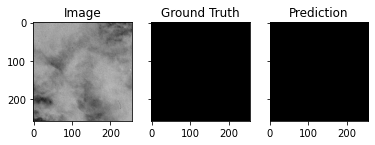

<Figure size 432x288 with 0 Axes>

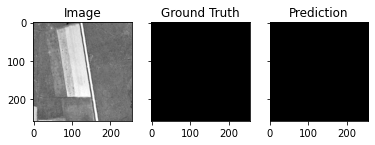

<Figure size 432x288 with 0 Axes>

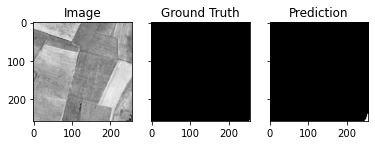

<Figure size 432x288 with 0 Axes>

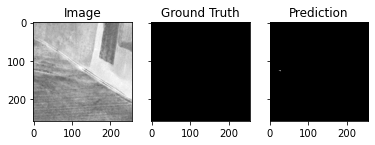

<Figure size 432x288 with 0 Axes>

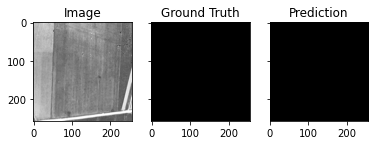

<Figure size 432x288 with 0 Axes>

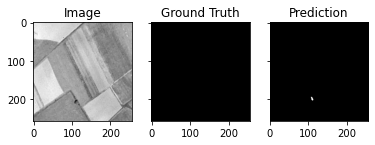

<Figure size 432x288 with 0 Axes>

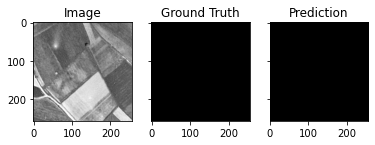

<Figure size 432x288 with 0 Axes>

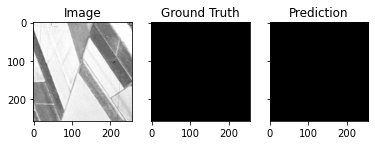

<Figure size 432x288 with 0 Axes>

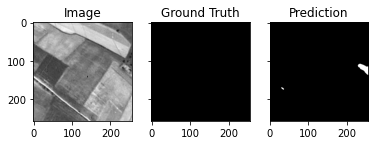

<Figure size 432x288 with 0 Axes>

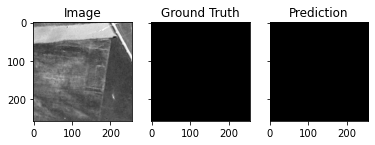

<Figure size 432x288 with 0 Axes>

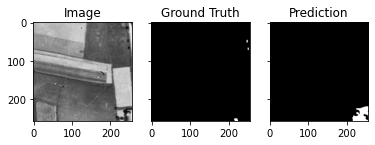

<Figure size 432x288 with 0 Axes>

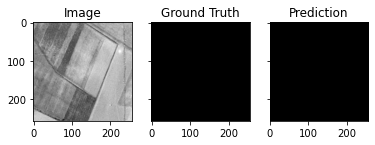

<Figure size 432x288 with 0 Axes>

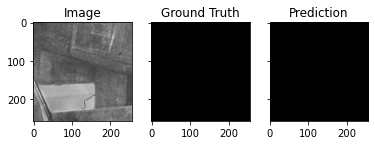

<Figure size 432x288 with 0 Axes>

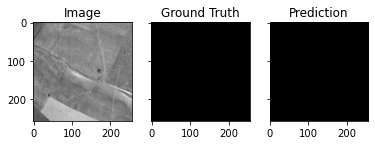

<Figure size 432x288 with 0 Axes>

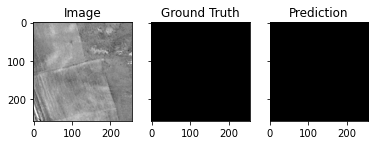

<Figure size 432x288 with 0 Axes>

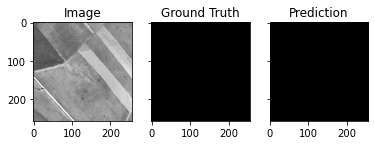

<Figure size 432x288 with 0 Axes>

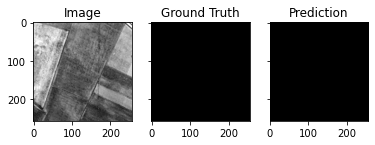

<Figure size 432x288 with 0 Axes>

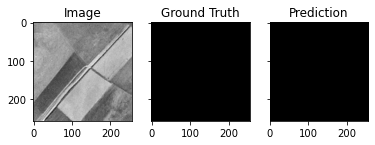

<Figure size 432x288 with 0 Axes>

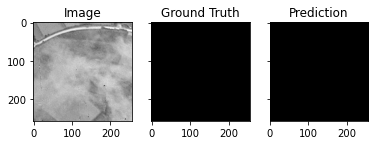

<Figure size 432x288 with 0 Axes>

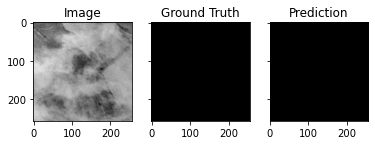

<Figure size 432x288 with 0 Axes>

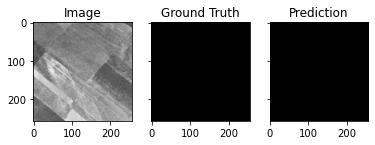

<Figure size 432x288 with 0 Axes>

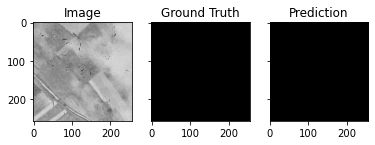

<Figure size 432x288 with 0 Axes>

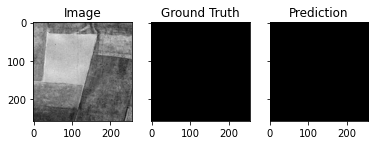

<Figure size 432x288 with 0 Axes>

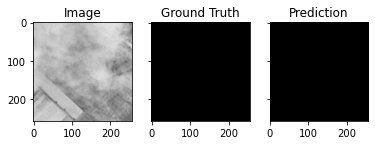

<Figure size 432x288 with 0 Axes>

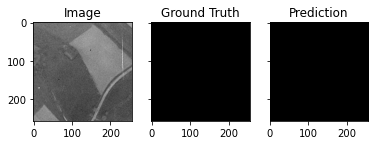

<Figure size 432x288 with 0 Axes>

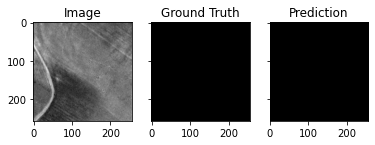

<Figure size 432x288 with 0 Axes>

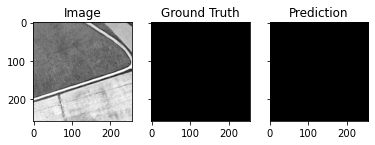

<Figure size 432x288 with 0 Axes>

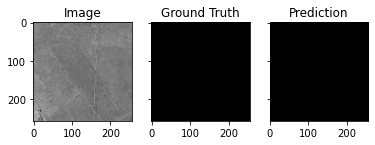

<Figure size 432x288 with 0 Axes>

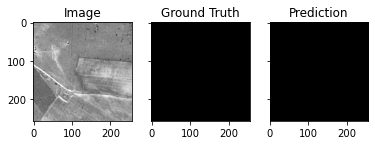

<Figure size 432x288 with 0 Axes>

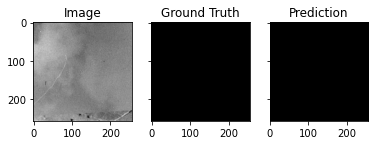

<Figure size 432x288 with 0 Axes>

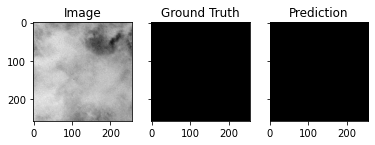

<Figure size 432x288 with 0 Axes>

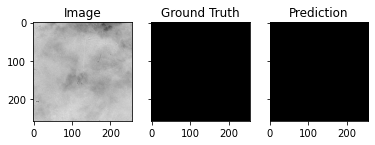

<Figure size 432x288 with 0 Axes>

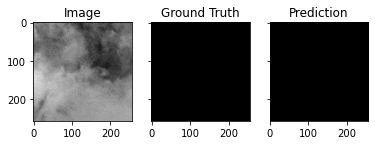

<Figure size 432x288 with 0 Axes>

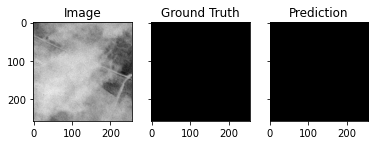

<Figure size 432x288 with 0 Axes>

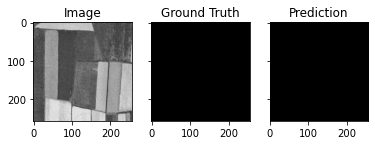

<Figure size 432x288 with 0 Axes>

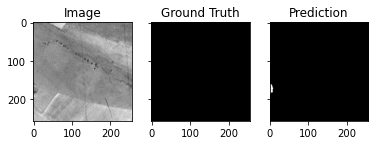

<Figure size 432x288 with 0 Axes>

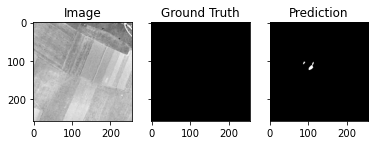

<Figure size 432x288 with 0 Axes>

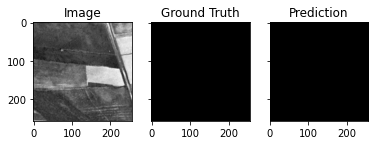

<Figure size 432x288 with 0 Axes>

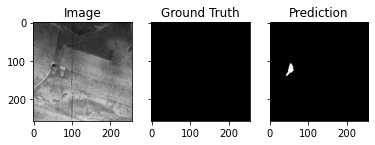

<Figure size 432x288 with 0 Axes>

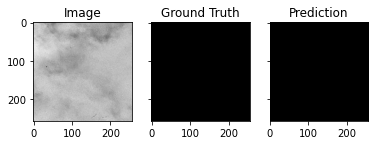

<Figure size 432x288 with 0 Axes>

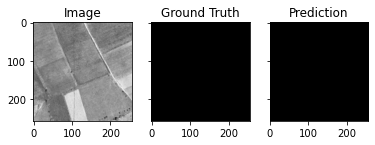

<Figure size 432x288 with 0 Axes>

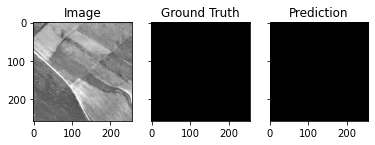

<Figure size 432x288 with 0 Axes>

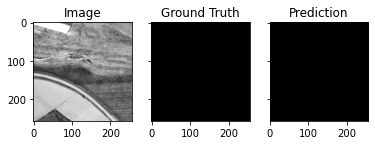

<Figure size 432x288 with 0 Axes>

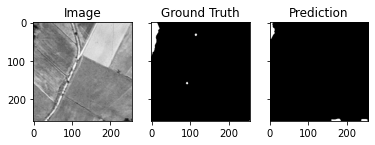

<Figure size 432x288 with 0 Axes>

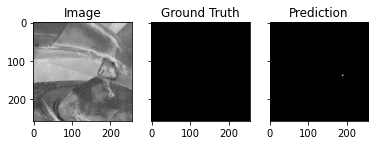

<Figure size 432x288 with 0 Axes>

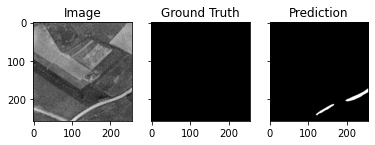

<Figure size 432x288 with 0 Axes>

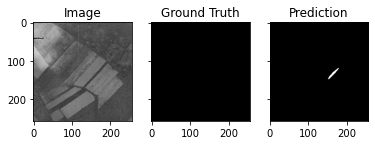

<Figure size 432x288 with 0 Axes>

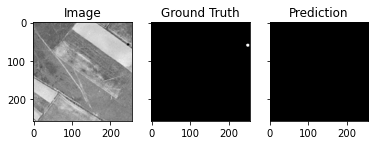

<Figure size 432x288 with 0 Axes>

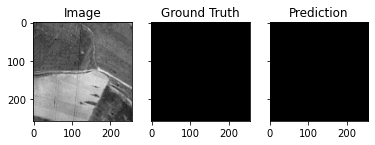

<Figure size 432x288 with 0 Axes>

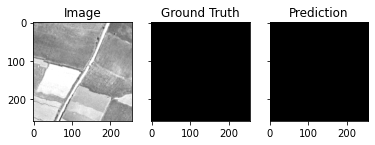

<Figure size 432x288 with 0 Axes>

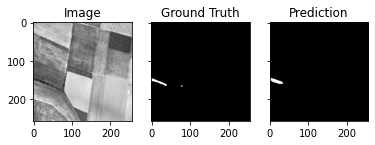

<Figure size 432x288 with 0 Axes>

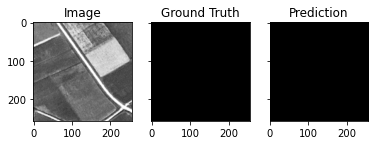

<Figure size 432x288 with 0 Axes>

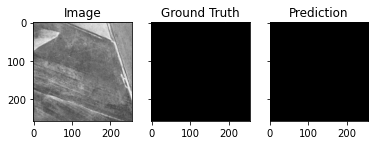

<Figure size 432x288 with 0 Axes>

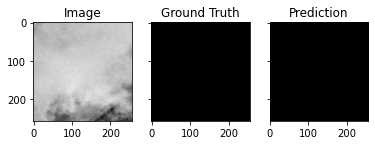

<Figure size 432x288 with 0 Axes>

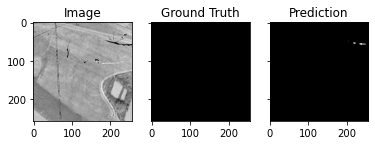

<Figure size 432x288 with 0 Axes>

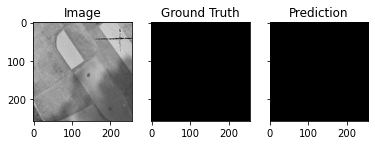

<Figure size 432x288 with 0 Axes>

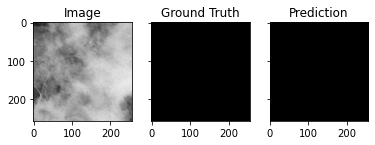

<Figure size 432x288 with 0 Axes>

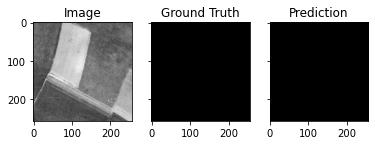

<Figure size 432x288 with 0 Axes>

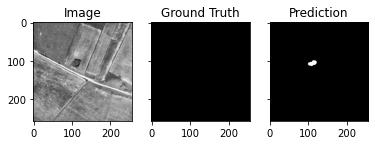

<Figure size 432x288 with 0 Axes>

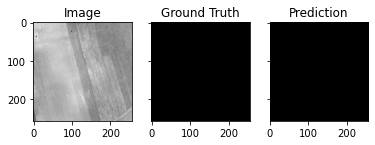

<Figure size 432x288 with 0 Axes>

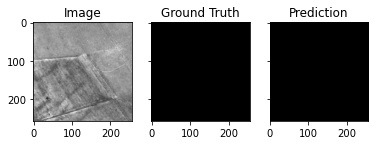

<Figure size 432x288 with 0 Axes>

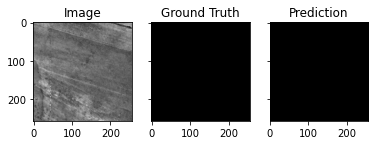

<Figure size 432x288 with 0 Axes>

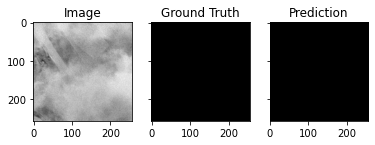

<Figure size 432x288 with 0 Axes>

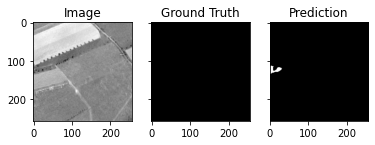

<Figure size 432x288 with 0 Axes>

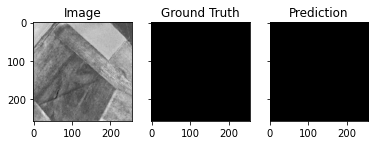

<Figure size 432x288 with 0 Axes>

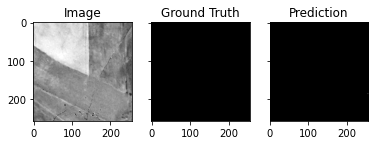

<Figure size 432x288 with 0 Axes>

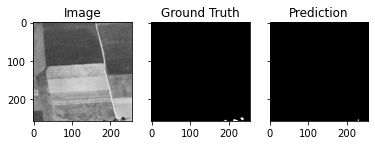

<Figure size 432x288 with 0 Axes>

In [51]:
# set the model in evaluation model
BEST_MODEL = '../best_model/without_attention/'
best_iou_model = glob.glob(BEST_MODEL + '/*.pth')[0]
# best_iou_model = [i for i in best_iou_model if i.startswith(data_portion, 14)][1]
print(best_iou_model)
folder = '../saved_images'

model_ = model.unet_model.to(config.DEVICE)
model_.load_state_dict(torch.load(best_iou_model))

y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder, print_pred=True, save_patches=False)

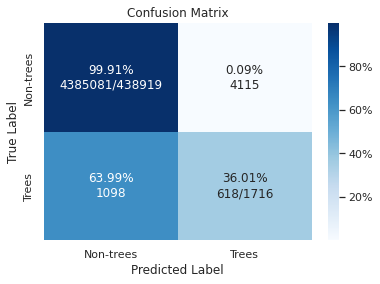

              precision    recall  f1-score   support

   Non-trees       1.00      1.00      1.00   4389196
       Trees       0.13      0.36      0.19      1716

    accuracy                           1.00   4390912
   macro avg       0.57      0.68      0.60   4390912
weighted avg       1.00      1.00      1.00   4390912

IoU 0.105985254
F1 score 0.19165763


In [52]:
labels = [0,1]
target_names = ['Non-trees', 'Trees']
metrics.cm_analysis(y_true, y_hat, labels, target_names)

In [12]:
total_non_trees = 4186845
correct_non_trees =267914
FN = 120671
FP = 233219

correct_non_trees / (correct_non_trees + FN
                    )

0.6894604784024088

In [ ]:
# rates = [20, 50, 100, 150, 200, 250, 285]

# # COARSE MODELS
# folder = '../saved_images'
# BEST_MODEL_COARSE = '../best_model/coarse_sizes'
# best_iou_model_coarse = glob.glob(BEST_MODEL_COARSE + '/*.pth')
# best_iou_model_coarse = sorted(best_iou_model_coarse, key= lambda x: int(re.split(r"[/_.]\s*", x)[8])) # sort files based on the number of patches

# # FINE MODELS
# BEST_MODEL_FINE = '../best_model/fine_sizes'
# best_iou_model_fine = glob.glob(BEST_MODEL_FINE + '/*.pth')
# best_iou_model_fine = sorted(best_iou_model_fine, key= lambda x: int(re.split(r"[/_.]\s*", x)[8])) # sort files based on the number of patches
  
# iou_coarse = utis.iou_on_test_dataset(best_iou_model_coarse, rates, test_dataloader, X_test, folder)
# iou_fine = utis.iou_on_test_dataset(best_iou_model_fine, rates, test_dataloader, X_test, folder)

# plt.figure(figsize=(10,10))
# plt.plot(iou_coarse.keys(),  iou_coarse.values(), label='coarse', marker='o')
# plt.plot(iou_fine.keys(),  iou_fine.values(), label = 'fine', marker='o')
# plt.legend()
# plt.xlabel('NUMBER OF PATCHES')
# plt.ylabel('IOU')
# plt.title(f'COARSE DATASET X FINE DATASET')
# plt.show()

In [ ]:
# # WandB – Initialize a new run
# # wandb.init(entity="vibferreira", project="master_thesis")

# # set the model in evaluation model
# data_portion= 'coarse_labels'
# BEST_MODEL = '../best_model'
# best_iou_model = glob.glob(BEST_MODEL + '/*.pth')
# best_iou_model = [i for i in best_iou_model if i.startswith(data_portion, 14)][0]
# print(best_iou_model)
# folder = '../saved_images'

# # load the model 
# model_ = model.unet_model.to(config.DEVICE)
# model_.load_state_dict(torch.load(best_iou_model))

# y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder)

In [ ]:
# # set the model in evaluation model
# BEST_MODEL = '../best_model'
# best_iou_model = glob.glob(BEST_MODEL + '/*.pth')
# best_iou_model.sort()
# portions = ['coarse_plus_fine_labels', 'coarse_labels', 'fine_labels']
# portions.sort()
# folder = '../saved_images'

# for i, p in zip(best_iou_model, portions):
#     # load the model 
#     model_ = model.unet_model.to(config.DEVICE)
#     model_.load_state_dict(torch.load(i))
    
#     y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder, print_pred=False)
#     y_hat, y_true, y_score = y_hat.detach().cpu().numpy(), y_true.detach().cpu().numpy(), y_score.detach().cpu().numpy()
    
#     fpr, tpr, thresholds = roc_curve(y_true, y_score)
#     roc_auc = auc(fpr, tpr)

#     lw = 2
#     plt.plot([0, 1], [0, 1], color='navy', linestyle='--', alpha=0.15)
#     plt.plot(fpr, tpr, lw=lw, label=f'{p} (area = {roc_auc: 0.4f})')

#     plt.xlabel('Specificity - False Positive Rate')
#     plt.ylabel('Sensitivity - True Positive Rate')
#     plt.title(f'ROC')
#     plt.legend(loc="lower right")